In [ ]:
!pip install torch torchvision transformers timm tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm import tqdm
import numpy as np

#  Step 1: Setup GPU & Mixed Precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler()

print(f"Using device: {device}")

#  Step 2: Generate Synthetic Dataset
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(224, 224)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data = self.generate_synthetic_data()

    def generate_synthetic_data(self):
        """ Generate synthetic images with random patterns """
        return [np.random.rand(*self.image_size, 3) * 255 for _ in range(self.num_samples)]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.uint8)
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224))(image)
        image = transforms.Normalize(mean=[0.5], std=[0.5])(image)
        label = np.random.randint(0, 10)
        return image, label

synthetic_dataset = SyntheticDataset(num_samples=1000)
synthetic_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True, num_workers=4)

#  Step 3: Load Pre-Trained Vision Transformer
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10)
model.to(device)

#  Step 4: Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
Segment-Anything
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

#  Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

#  Step 6: Train Model
def train_model(model, dataloader, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(dataloader))

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

train_model(model, synthetic_loader, epochs=2)

# Save Model
torch.save(model.state_dict(), "pretrained_vit_fixed.pth")

#  Step 7: Fine-Tune Model
def fine_tune_model(model, train_loader, test_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(train_loader))

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate Model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

fine_tune_model(model, train_loader, test_loader, epochs=3)

# Save Fine-Tuned Model
torch.save(model.state_dict(), "fine_tuned_vit_fixed.pth")

#  Step 8: Model Evaluation
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(accuracy=100 * correct / total)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

model.load_state_dict(torch.load("fine_tuned_vit_fixed.pth"))
test_model(model, test_loader)


<ipython-input-13-3916738ee51a>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Files already downloaded and verified
Files already downloaded and verified


Epoch [1/2]:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-13-3916738ee51a>:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/2], Loss: 2.3137


Epoch [2/2], Loss: 2.3148


Epoch [1/3]:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-13-3916738ee51a>:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/3], Loss: 0.2829


Epoch [2/3], Loss: 0.1139


Epoch [3/3], Loss: 0.0890


Test Accuracy: 95.14%


<ipython-input-13-3916738ee51a>:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_vit_fixed.pth"))
                            

Final Test Accuracy: 95.14%


In [ ]:
from PIL import Image

def predict_image(model, image_tensor):
    model.eval()

    # Convert torch.Tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor)

    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image).logits
        _, predicted = torch.max(outputs, 1)

    print(f"Predicted Class: {predicted.item()}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Plot Image with Prediction
def plot_image_with_prediction(model, dataset, index=0):
    """Plots an image from the dataset along with its predicted label."""
    model.eval()

    image, true_label = dataset[index]
    image_pil = transforms.ToPILImage()(image)

    # Transform image for model input
    image_input = transform(image_pil).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        outputs = model(image_input).logits
        _, predicted_label = torch.max(outputs, 1)

    # Display image with predicted label
    plt.imshow(image_pil)
    plt.title(f"True: {true_label} | Predicted: {predicted_label.item()}")
    plt.axis("off")
    plt.show()

# Step 2: Compute and Plot Confusion Matrix
def compute_and_plot_confusion_matrix(model, test_loader, class_names):
    """Computes and displays a confusion matrix."""
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Evaluating: 100%|██████████| 157/157 [01:58<00:00,  1.33it/s]


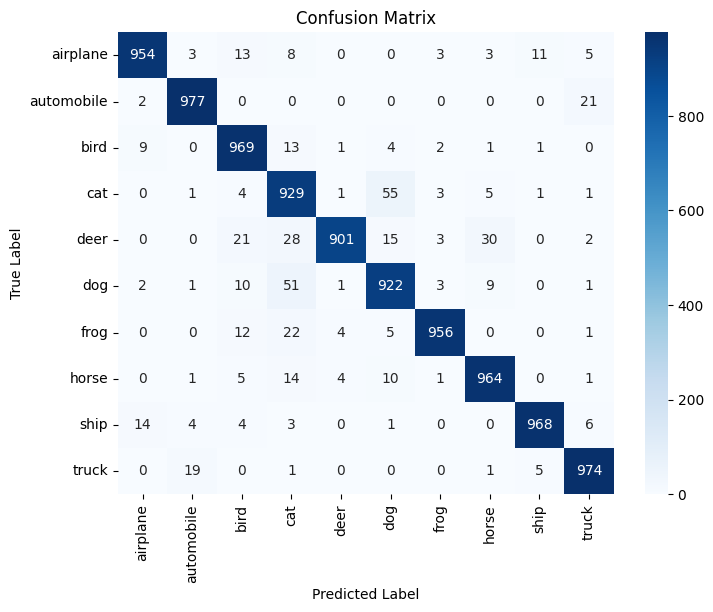

In [ ]:
class_names = train_dataset.classes  # CIFAR-10 class names
compute_and_plot_confusion_matrix(model, test_loader, class_names)


Files already downloaded and verified


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-18-578c5b0a7a00>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

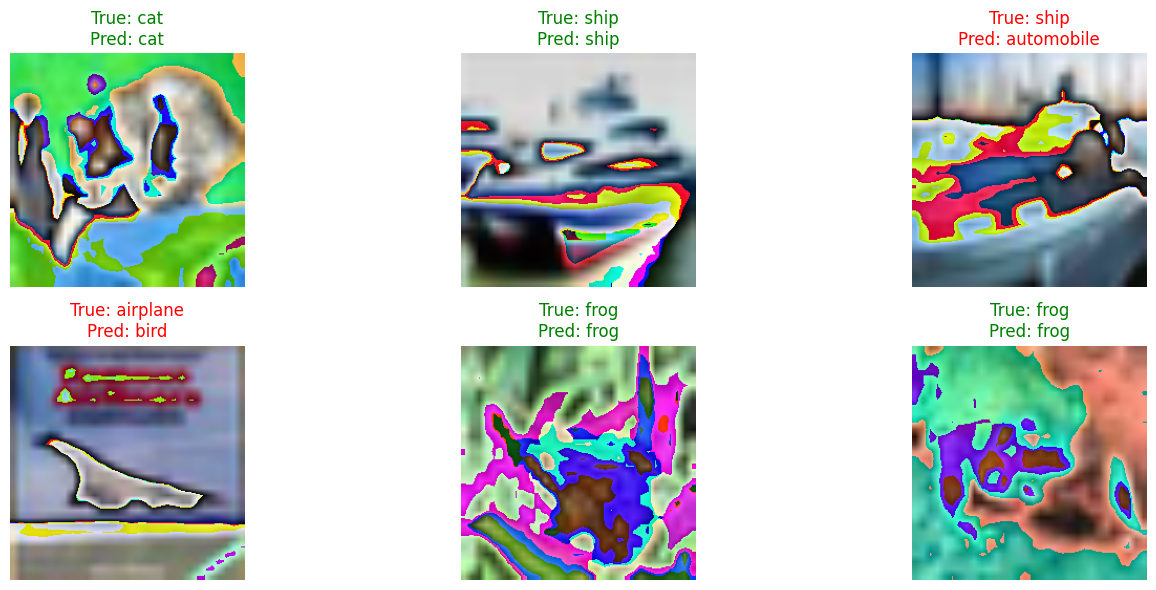

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm import tqdm

#  Step 1: Load CIFAR-10 Test Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = test_dataset.classes

#  Step2: Load Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10)
model.load_state_dict(torch.load("fine_tuned_vit_fixed.pth"))  # Load your trained model
model.to(device)
model.eval()

#  Step3: Plot Actual vs Predicted Images
def plot_actual_vs_predicted(model, dataset, num_images=6):
    """Plots actual CIFAR-10 images alongside their predicted labels."""
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))

    for i in range(num_images):
        image, true_label = dataset[i]  # Get image and label
        image_pil = transforms.ToPILImage()(image)  # Convert tensor to PIL Image

        # Transform image for model input
        image_input = transform(image_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_input).logits
            _, predicted_label = torch.max(outputs, 1)

        predicted_label = predicted_label.item()
        true_label_name = class_names[true_label]
        predicted_label_name = class_names[predicted_label]

        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(image_pil)
        ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=12,
                     color="green" if true_label == predicted_label else "red")  # Green if correct, red if wrong
        ax.axis("off")

    plt.tight_layout()
    plt.show()

#  Step 4: Run the Function to Display Images
plot_actual_vs_predicted(model, test_dataset, num_images=6)
